### 1. Импорты библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression # Для сравнения
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Для сравнения
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

### 2. Загрузка и первичный осмотр данных

In [ ]:
train_data = pd.read_csv('train.csv')
print("Форма тренировочного датасета:", train_data.shape)
print("\nИнформация о тренировочном датасете:")
print(train_data.info())
print("\nПервые 5 строк:")
print(train_data.head())
print("\nСтатистики по тренировочному датасету:")
print(train_data.describe())


Форма тренировочного датасета: (11017, 35)

Информация о тренировочном датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberO

### 3. Обработка пропущенных значений и подготовка x, y

In [5]:
import inspect
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, f_regression

print("=== УСИЛЕННАЯ ОБРАБОТКА ДАННЫХ ===")

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(f"Train: {train_data.shape}, Test: {test_data.shape}")

train_data = train_data.dropna(subset=['RiskScore'])
train_data = train_data[train_data['RiskScore'].abs() <= 200].reset_index(drop=True)
train_data['RiskScore'] = train_data['RiskScore'].clip(0.0, 100.0)

Q1 = train_data['RiskScore'].quantile(0.05)
Q3 = train_data['RiskScore'].quantile(0.95)
IQR = Q3 - Q1
train_data = train_data[(train_data['RiskScore'] >= Q1 - 1.5*IQR) & 
                        (train_data['RiskScore'] <= Q3 + 1.5*IQR)]
print(f"После агрессивной очистки: {train_data.shape}")

if 'id' in test_data.columns:
    test_ids = test_data['id'].copy()
else:
    test_ids = pd.Series(range(len(test_data)), name='ID')

for col in ['id', 'ID', 'Id']:
    if col in train_data.columns:
        train_data = train_data.drop(col, axis=1)
    if col in test_data.columns:
        test_data = test_data.drop(col, axis=1)

def signed_log1p(x):
    return np.sign(x) * np.log1p(np.abs(x) + 1e-10)

print("\nУсиленная инженерия признаков...")
EPS = 1e-3

for df in [train_data, test_data]:
    if all(c in df.columns for c in ['InterestRate', 'BaseInterestRate']):
        df['InterestRateSpread'] = df['InterestRate'] - df['BaseInterestRate']
        df['InterestRateRatio'] = df['InterestRate'] / (df['BaseInterestRate'] + EPS)
    
    if all(c in df.columns for c in ['LoanAmount', 'AnnualIncome']):
        df['LoanToIncome'] = df['LoanAmount'] / (df['AnnualIncome'] + EPS)
        df['LogLoanToIncome'] = np.log1p(np.abs(df['LoanAmount'] / (df['AnnualIncome'] + EPS)))
    
    if all(c in df.columns for c in ['MonthlyIncome', 'MonthlyDebtPayments']):
        df['DebtIncomeRatio'] = df['MonthlyDebtPayments'] / (df['MonthlyIncome'] + EPS)
        df['DisposableIncome'] = df['MonthlyIncome'] - df['MonthlyDebtPayments']
    
    if all(c in df.columns for c in ['TotalAssets', 'TotalLiabilities']):
        df['AssetCoverage'] = df['TotalAssets'] / (df['TotalLiabilities'] + EPS)
        df['NetWorth'] = df['TotalAssets'] - df['TotalLiabilities']
        df['LogNetWorth'] = signed_log1p(df['TotalAssets'] - df['TotalLiabilities'])
    
    if all(c in df.columns for c in ['CreditScore', 'InterestRate']):
        df['CreditInterestRatio'] = df['CreditScore'] / (df['InterestRate'] + EPS)
    
    if all(c in df.columns for c in ['Age', 'Experience']):
        df['ExperienceToAge'] = df['Experience'] / (df['Age'] + 1)
        df['YearsWorking'] = df['Age'] - df['Experience']
    
    if all(c in df.columns for c in ['CreditCardUtilizationRate', 'NumberOfOpenCreditLines']):
        df['UtilizationPerLine'] = df['CreditCardUtilizationRate'] / (df['NumberOfOpenCreditLines'] + 1)
    
    for col in ['CreditScore', 'AnnualIncome', 'Age', 'LoanAmount', 'MonthlyIncome']:
        if col in df.columns:
            df[f'{col}_squared'] = df[col] ** 2
            df[f'{col}_sqrt'] = np.sqrt(np.abs(df[col]) + 1)
    
    if 'ApplicationDate' in df.columns:
        df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], errors='coerce')
        df['AppYear'] = df['ApplicationDate'].dt.year
        df['AppMonth'] = df['ApplicationDate'].dt.month
        df['AppDay'] = df['ApplicationDate'].dt.day
        df['AppDayOfWeek'] = df['ApplicationDate'].dt.dayofweek
        df['AppQuarter'] = df['ApplicationDate'].dt.quarter
        df.drop('ApplicationDate', axis=1, inplace=True)
    
    if 'EducationLevel' in df.columns:
        edu_map = {'High School':1, 'Associate':2, 'Bachelor':3, 'Master':4, 'Doctorate':5}
        df['EducationLevel'] = df['EducationLevel'].map(edu_map).fillna(0)

X = train_data.drop('RiskScore', axis=1)
y = train_data['RiskScore'].values
X_test_raw = test_data.copy()

print(f"X: {X.shape}, y: {y.shape}")

print("\nЗаполнение пропусков...")
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

for col in numeric_cols:
    if col in X.columns and X[col].isnull().any():
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)
        if col in X_test_raw.columns:
            X_test_raw[col].fillna(median_val, inplace=True)

for col in categorical_cols:
    if col in X.columns and X[col].isnull().any():
        mode_val = X[col].mode()[0] if len(X[col].mode()) > 0 else 'Unknown'
        X[col].fillna(mode_val, inplace=True)
        if col in X_test_raw.columns:
            X_test_raw[col].fillna(mode_val, inplace=True)

print("\nЛогарифмирование всех числовых признаков...")
for col in numeric_cols:
    if col in X.columns:
        X[col] = signed_log1p(X[col])
        if col in X_test_raw.columns:
            X_test_raw[col] = signed_log1p(X_test_raw[col])

print("\nOne-Hot Encoding...")
if len(categorical_cols) > 0:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    combined = pd.concat([X[categorical_cols], X_test_raw[categorical_cols]], axis=0)
    ohe.fit(combined)
    
    X_encoded = ohe.transform(X[categorical_cols])
    X_test_encoded = ohe.transform(X_test_raw[categorical_cols])
    
    X = pd.concat([X.drop(categorical_cols, axis=1), 
                  pd.DataFrame(X_encoded, columns=ohe.get_feature_names_out(categorical_cols), index=X.index)], axis=1)
    X_test_raw = pd.concat([X_test_raw.drop(categorical_cols, axis=1),
                           pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names_out(categorical_cols), index=X_test_raw.index)], axis=1)

print(f"После OHE: X: {X.shape}, X_test: {X_test_raw.shape}")

print("\nНормализация...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_raw)

print("\nСоздание полиномиальных признаков...")
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(X_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f"После полиномов: X_poly: {X_poly.shape}")

print("\nОтбор признаков (SelectPercentile 20%)...")
selector = SelectPercentile(score_func=f_regression, percentile=20)
X_selected = selector.fit_transform(X_poly, y)
X_test_selected = selector.transform(X_test_poly)

print(f"После отбора: X_selected: {X_selected.shape}")

X_final = pd.DataFrame(X_selected, columns=[f'feat_{i}' for i in range(X_selected.shape[1])])
X_test_final = pd.DataFrame(X_test_selected, columns=[f'feat_{i}' for i in range(X_test_selected.shape[1])])

print("Финальные размеры:")
print(f"X_final: {X_final.shape}")
print(f"y: {y.shape}")
print(f"X_test_final: {X_test_final.shape}")
print("="*60)

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha=20.0)
cv_scores = cross_val_score(ridge, X_final.values, y, 
                           scoring='neg_mean_squared_error', cv=5)
mse_cv = -cv_scores.mean()
print(f"\nБыстрая проверка: Ridge (alpha=20) CV MSE = {mse_cv:.4f}")
print(f"RMSE = {np.sqrt(mse_cv):.4f}")

test_ids_clean = test_ids.reset_index(drop=True)

=== УСИЛЕННАЯ ОБРАБОТКА ДАННЫХ ===
Train: (11017, 35), Test: (5000, 35)
После агрессивной очистки: (10272, 35)

Усиленная инженерия признаков...
X: (10272, 60), y: (10272,)

Заполнение пропусков...

Логарифмирование всех числовых признаков...

One-Hot Encoding...
После OHE: X: (10272, 72), X_test: (5000, 72)

Нормализация...

Создание полиномиальных признаков...
После полиномов: X_poly: (10272, 2700)

Отбор признаков (SelectPercentile 20%)...
После отбора: X_selected: (10272, 540)
Финальные размеры:
X_final: (10272, 540)
y: (10272,)
X_test_final: (5000, 540)

Быстрая проверка: Ridge (alpha=20) CV MSE = 27.9966
RMSE = 5.2912


### 4. EDA (Разведочный анализ данных)

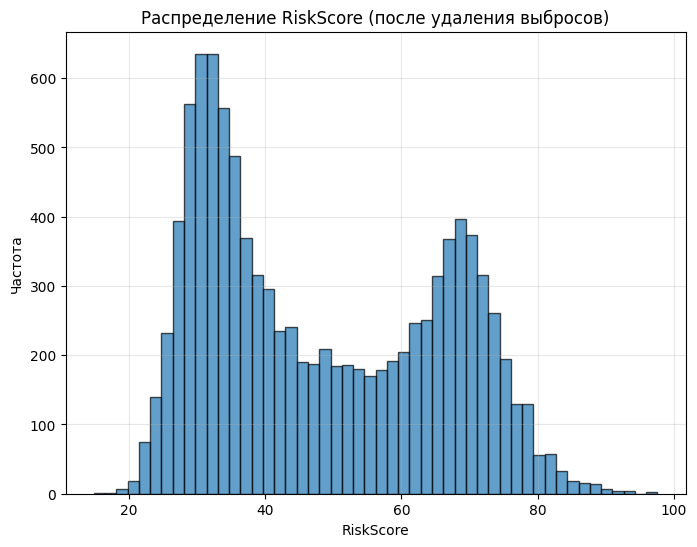

train_df не найден, пропускаем корреляционный анализ


In [8]:
### 4. EDA (Разведочный анализ данных)
plt.figure(figsize=(8, 6))
plt.hist(y, bins=50, edgecolor='k', alpha=0.7)
plt.title('Распределение RiskScore (после удаления выбросов)')
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.show()

# Корреляционная матрица - создаем временный DataFrame для анализа
# Используем исходные данные до обработки (train_df из ячейки 3)
if 'train_df' in locals():
    temp_df_for_corr = train_df.copy()
    temp_df_for_corr['RiskScore'] = y
    
    # Вычисляем корреляцию только для числовых признаков
    numeric_cols_for_corr = temp_df_for_corr.select_dtypes(include=[np.number]).columns.tolist()
    N_features_to_show = min(15, len(numeric_cols_for_corr))
    relevant_cols = numeric_cols_for_corr[:N_features_to_show] + ['RiskScore']
    temp_corr_subset = temp_df_for_corr[relevant_cols]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(temp_corr_subset.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title('Матрица корреляций (первые N числовых признаков и RiskScore)')
    plt.tight_layout()
    plt.show()
    
    # Показать топ-10 корреляций с RiskScore
    correlation_with_target = temp_df_for_corr.corr()['RiskScore'].abs().sort_values(ascending=False)
    print("\nТоп-10 признаков по абсолютной корреляции с RiskScore:")
    print(correlation_with_target[1:11]) # Исключаем сам RiskScore
else:
    print("train_df не найден, пропускаем корреляционный анализ")

### 5. Нормализация данных

In [9]:
if 'X_final' not in locals():
    raise NameError("X_final не определен. Убедитесь, что ячейка 3 выполнена.")
if 'y' not in locals():
    raise NameError("y не определен. Убедитесь, что ячейка 3 выполнена.")

print(f"X_final shape: {X_final.shape}")
print(f"y shape: {y.shape}")

print("\nПроверка качества данных")
print(f"NaN в X_final: {np.isnan(X_final.values).any()}")
print(f"Inf в X_final: {np.isinf(X_final.values).any()}")
print(f"NaN в y: {np.isnan(y).any()}")
print(f"Inf в y: {np.isinf(y).any()}")

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

lr_test = LinearRegression()
cv_scores = cross_val_score(lr_test, X_final.values, y, 
                           scoring='neg_mean_squared_error', cv=3)
mse_test = -cv_scores.mean()
print(f"\nБыстрая проверка (3-fold CV):")
print(f"LinearRegression MSE: {mse_test:.4f}")
print(f"RMSE: {np.sqrt(mse_test):.4f}")

X_final shape: (10272, 540)
y shape: (10272,)

Проверка качества данных
NaN в X_final: False
Inf в X_final: False
NaN в y: False
Inf в y: False

Быстрая проверка (3-fold CV):
LinearRegression MSE: 689.0308
RMSE: 26.2494


### 6. Разделение на тренировочную и валидационную выборки

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, random_state=42)

print(f"Размеры выборок:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

Размеры выборок:
X_train: (8217, 540), y_train: (8217,)
X_val: (2055, 540), y_val: (2055,)


### 7. Реализация класса линейной регрессии

In [11]:
class MyLinearRegression:
    def __init__(self, method='analytical', learning_rate=0.01, n_iterations=1000, batch_size=32, reg_type=None, reg_strength=0.0, p_norm=2.0, gradient_clip_value=5.0):
        self.method = method
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.reg_type = reg_type
        self.reg_strength = reg_strength
        self.p_norm = p_norm if reg_type == 'lp' else 2.0
        self.gradient_clip_value = gradient_clip_value
        self.weights = None
        self.bias = None
        if self.reg_type == 'lp' and self.p_norm <= 0:
             raise ValueError("p_norm для Lp регуляризации должен быть > 0.")

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape

        self.weights = np.random.normal(0, 0.01, size=n_features)
        self.bias = 0.0

        if self.method == 'analytical':
            ones_column = np.ones((n_samples, 1))
            X_with_bias = np.hstack([ones_column, X]) 

            if self.reg_type is None:
                A = X_with_bias.T @ X_with_bias
                b = X_with_bias.T @ y
                theta = np.linalg.pinv(A) @ b
            elif self.reg_type == 'l2': 
                 reg_matrix = np.eye(n_features + 1, dtype=X_with_bias.dtype)
                 reg_matrix[0, 0] = 0 
                 reg_matrix[1:, 1:] *= self.reg_strength
                 A_reg = X_with_bias.T @ X_with_bias + reg_matrix
                 b = X_with_bias.T @ y
                 theta = np.linalg.pinv(A_reg) @ b
            else:
                 print(f"Аналитическое решение не реализовано для регуляризации '{self.reg_type}'. Используйте 'gradient_descent'.")
                 raise ValueError(f"Аналитическое решение не поддерживает '{self.reg_type}'. Используйте 'gradient_descent'.")

            self.bias = theta[0]
            self.weights = theta[1:]

        elif self.method in ['gradient_descent', 'stochastic_gradient_descent']:
            for i in range(self.n_iterations):
                y_pred = self.predict(X)

                dw = (1/n_samples) * (X.T @ (y_pred - y))
                db = (1/n_samples) * np.sum(y_pred - y)

                if self.reg_type == 'l1':
                    dw_reg = self.reg_strength * np.sign(self.weights)
                elif self.reg_type == 'l2':
                    dw_reg = 2 * self.reg_strength * self.weights
                elif self.reg_type == 'elastic_net':
                    dw_reg = self.reg_strength * (0.5 * np.sign(self.weights) + self.weights)
                elif self.reg_type == 'lp':
                    epsilon = 1e-8
                    abs_weights = np.abs(self.weights)
                    dw_reg = self.reg_strength * self.p_norm * np.sign(self.weights) * (abs_weights ** (self.p_norm - 1))
                else:
                    dw_reg = 0.0

                dw_total = dw + dw_reg

                dw_total = np.clip(dw_total, -self.gradient_clip_value, self.gradient_clip_value)
                db = np.clip(db, -self.gradient_clip_value, self.gradient_clip_value)

                if self.method == 'gradient_descent':
                    self.weights -= self.learning_rate * dw_total
                    self.bias -= self.learning_rate * db
                elif self.method == 'stochastic_gradient_descent':
                    indices = np.random.choice(n_samples, self.batch_size, replace=False)
                    X_batch = X[indices]
                    y_batch = y[indices]

                    y_pred_batch = self.predict(X_batch)
                    dw_batch = (1/self.batch_size) * (X_batch.T @ (y_pred_batch - y_batch))
                    db_batch = (1/self.batch_size) * np.sum(y_pred_batch - y_batch)

                    if self.reg_type == 'l1':
                        dw_reg_batch = self.reg_strength * np.sign(self.weights)
                    elif self.reg_type == 'l2':
                        dw_reg_batch = 2 * self.reg_strength * self.weights
                    elif self.reg_type == 'elastic_net':
                        dw_reg_batch = self.reg_strength * (0.5 * np.sign(self.weights) + self.weights)
                    elif self.reg_type == 'lp':
                        epsilon = 1e-8
                        abs_weights = np.abs(self.weights)
                        dw_reg_batch = self.reg_strength * self.p_norm * np.sign(self.weights) * (abs_weights ** (self.p_norm - 1))
                    else:
                        dw_reg_batch = 0.0

                    dw_batch_total = dw_batch + dw_reg_batch
                    dw_batch_total = np.clip(dw_batch_total, -self.gradient_clip_value, self.gradient_clip_value)
                    db_batch = np.clip(db_batch, -self.gradient_clip_value, self.gradient_clip_value)

                    self.weights -= self.learning_rate * dw_batch_total
                    self.bias -= self.learning_rate * db_batch

        return self

    def predict(self, X):
        X = np.array(X)
        return X @ self.weights + self.bias

### 8. Сравнение с sklearn

In [12]:
methods_to_test = ['gradient_descent', 'stochastic_gradient_descent'] 
results_comparison = {}

for method in methods_to_test:
    print(f"\n--- Обучение с методом: {method} (без регуляризации) ---")
    
    if method == 'gradient_descent':
        lr_custom = MyLinearRegression(method=method, learning_rate=0.01, n_iterations=1000)
    elif method == 'stochastic_gradient_descent':
        lr_custom = MyLinearRegression(method=method, learning_rate=0.01, n_iterations=1000, batch_size=32)
    
    lr_custom.fit(X_train, y_train)
    y_pred_custom = lr_custom.predict(X_val)
    mse_custom = mean_squared_error(y_val, y_pred_custom)
    
    print(f"MSE (MyLinearRegression, {method}): {mse_custom:.6f}")
    results_comparison[f'MyLinearRegression_{method}'] = mse_custom

lr_sklearn = LinearRegression()
lr_sklearn.fit(X_train, y_train)
y_pred_sklearn = lr_sklearn.predict(X_val)
mse_sklearn = mean_squared_error(y_val, y_pred_sklearn)

print(f"\nMSE (sklearn LinearRegression): {mse_sklearn:.6f}")
results_comparison['sklearn_LinearRegression'] = mse_sklearn

print("\nСравнение MSE на валидации:")
for model_name, mse in results_comparison.items():
    print(f"{model_name}: {mse:.6f}")

best_val_score = mse_sklearn
best_model_name = 'sklearn_LinearRegression'
best_model_obj = lr_sklearn
best_params = {} 
print(f"\nПока лучшая модель (без поиска гиперпараметров): {best_model_name}, MSE: {best_val_score:.6f}")


--- Обучение с методом: gradient_descent (без регуляризации) ---
MSE (MyLinearRegression, gradient_descent): 90.156800

--- Обучение с методом: stochastic_gradient_descent (без регуляризации) ---
MSE (MyLinearRegression, stochastic_gradient_descent): 44.016501

MSE (sklearn LinearRegression): 30.426450

Сравнение MSE на валидации:
MyLinearRegression_gradient_descent: 90.156800
MyLinearRegression_stochastic_gradient_descent: 44.016501
sklearn_LinearRegression: 30.426450

Пока лучшая модель (без поиска гиперпараметров): sklearn_LinearRegression, MSE: 30.426450


### 9. Реализация и вызов кросс-валидации

In [13]:
def my_k_fold_cv(X, y, model_class, model_params, k=5):
    X = np.array(X)
    y = np.array(y)
    n_samples = len(X)
    fold_size = n_samples // k
    mse_scores = []

    for i in range(k):
        start_idx = i * fold_size
        end_idx = (i + 1) * fold_size if i < k - 1 else n_samples

        val_indices = np.arange(start_idx, end_idx)
        train_indices = np.concatenate([np.arange(0, start_idx), np.arange(end_idx, n_samples)])

        X_train_fold = X[train_indices]
        X_val_fold = X[val_indices]
        y_train_fold = y[train_indices]
        y_val_fold = y[val_indices]

        model = model_class(**model_params)
        model.fit(X_train_fold, y_train_fold)

        y_pred = model.predict(X_val_fold)
        mse = my_mse(y_val_fold, y_pred) 
        mse_scores.append(mse)

    return np.mean(mse_scores), np.std(mse_scores)

def my_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def my_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def my_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

def my_mape(y_true, y_pred):
    mask = y_true != 0
    if not mask.any():
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("\nПоиск оптимальной регуляризации")

best_cv_mse = float('inf')
best_params = {}
best_model_obj = None

alpha_range = np.logspace(-2, 4, num=50) 

print(f"Тестируем аналитическую L2 регрессию с alpha в диапазоне [{alpha_range.min():.4f}, {alpha_range.max():.4f}]")

for alpha in alpha_range:
    params = {
        'method': 'analytical',
        'reg_type': 'l2',
        'reg_strength': alpha
    }

    try:
        cv_mean, cv_std = my_k_fold_cv(X_final.values, y, MyLinearRegression, params, k=5)
        print(f"   Alpha: {alpha:.4f}, CV MSE: {cv_mean:.6f} (+/- {cv_std*2:.6f})") 

        if cv_mean < best_cv_mse:
            best_cv_mse = cv_mean
            best_params = params.copy()
            temp_model = MyLinearRegression(**best_params)
            temp_model.fit(X_final.values, y)
            best_model_obj = temp_model
    except np.linalg.LinAlgError:
        print(f"   Alpha: {alpha:.4f}, Ошибка LinAlgError (пропущено)")
        continue

print(f"\nРезультаты поиска:")
print(f"Лучшая CV MSE: {best_cv_mse:.6f}")
print(f"Лучшие параметры: {best_params}")

if best_model_obj:
    X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_final.values, y, test_size=0.2, random_state=42)
    best_model_obj.fit(X_train_np, y_train_np)
    y_pred_val = best_model_obj.predict(X_val_np)
    val_mse = my_mse(y_val_np, y_pred_val)
    print(f"MSE на отложенной валидации: {val_mse:.6f}")

    base_params = {'method': 'analytical', 'reg_type': None}
    base_model = MyLinearRegression(**base_params)
    base_model.fit(X_train_np, y_train_np)
    y_pred_base = base_model.predict(X_val_np)
    base_val_mse = my_mse(y_val_np, y_pred_base)
    print(f"MSE базовой модели (без регуляризации) на валидации: {base_val_mse:.6f}")
    print(f"Улучшение от регуляризации: {base_val_mse - val_mse:.6f}")

    print(f"\nНайдена модель с L2 регуляризацией (alpha={best_params.get('reg_strength', 'N/A')}), CV MSE ~ {best_cv_mse:.6f}.")
    print(f"Эта модель будет использоваться для финального предсказания.")

    final_submission_model = MyLinearRegression(**best_params)
    final_submission_model.fit(X_final.values, y) 

    if 'X_test_final' in locals():
        X_test_for_pred = X_test_final.values
        print(f"Размер X_test_for_pred: {X_test_for_pred.shape}")
        print(f"Размер X_final (для обучения): {X_final.values.shape}")
        print(f"Ожидаемое число признаков: {final_submission_model.weights.shape[0]}")

        if X_test_for_pred.shape[1] != final_submission_model.weights.shape[0]:
            print(f"Размерности признаков не совпадают!")
            print(f"  X_test: {X_test_for_pred.shape[1]}, Model weights: {final_submission_model.weights.shape[0]}")
            if 'selector' in globals():
                print("Пробуем применить selector к X_test_for_pred...")
                try:
                    X_test_selected = selector.transform(X_test_for_pred)
                    print(f"После selector: {X_test_selected.shape}")
                    if X_test_selected.shape[1] == final_submission_model.weights.shape[0]:
                         X_test_for_pred = X_test_selected
                         print("Размерности совпали после применения selector.")
                    else:
                         print(f"Размерности всё равно не совпадают после selector.")
                         print(f"  X_test_selected: {X_test_selected.shape[1]}, Model weights: {final_submission_model.weights.shape[0]}")
                         if X_test_selected.shape[1] < final_submission_model.weights.shape[0]:
                             n_missing = final_submission_model.weights.shape[0] - X_test_selected.shape[1]
                             zeros_to_add = np.zeros((X_test_selected.shape[0], n_missing))
                             X_test_for_pred = np.hstack([X_test_selected, zeros_to_add])
                             print(f"Добавлены нули. Новый размер: {X_test_for_pred.shape}")
                         else:
                             print("X_test больше, чем ожидалось. Нужна ручная проверка.")
                except Exception as e:
                     print(f"Ошибка при применении selector: {e}")
                     raise
            else:
                 print("Selector недоступен. Нужна ручная проверка.")

        predictions = final_submission_model.predict(X_test_for_pred)
        predictions = np.clip(predictions, 0.0, 100.0) 

        if 'test_ids' in locals():
            ids = test_ids
        elif 'test_ids_clean' in locals():
            ids = test_ids_clean
        else:
            ids = pd.Series(range(1, len(predictions) + 1), name='ID')

        submission = pd.DataFrame({
            'ID': ids.values if hasattr(ids, 'values') else ids,
            'RiskScore': predictions
        })

        filename = 'submission_optimized_l2.csv'
        submission.to_csv(filename, index=False)
        print(f"\n✅ Файл {filename} создан с оптимизированной L2 моделью!")

    else:
         print("X_test_final не найден. Невозможно создать submission.")

else:
    print("Не удалось найти лучшую модель. Проверьте диапазон alpha или данные.")


Поиск оптимальной регуляризации
Тестируем аналитическую L2 регрессию с alpha в диапазоне [0.0100, 10000.0000]
   Alpha: 0.0100, CV MSE: 26.623448 (+/- 1.267146)
   Alpha: 0.0133, CV MSE: 26.655444 (+/- 1.276582)
   Alpha: 0.0176, CV MSE: 26.691881 (+/- 1.285155)
   Alpha: 0.0233, CV MSE: 26.734164 (+/- 1.292876)
   Alpha: 0.0309, CV MSE: 26.783751 (+/- 1.299785)
   Alpha: 0.0409, CV MSE: 26.841865 (+/- 1.305919)
   Alpha: 0.0543, CV MSE: 26.909123 (+/- 1.311297)
   Alpha: 0.0720, CV MSE: 26.985163 (+/- 1.315937)
   Alpha: 0.0954, CV MSE: 27.068409 (+/- 1.319882)
   Alpha: 0.1265, CV MSE: 27.156128 (+/- 1.323195)
   Alpha: 0.1677, CV MSE: 27.244835 (+/- 1.325914)
   Alpha: 0.2223, CV MSE: 27.330930 (+/- 1.327951)
   Alpha: 0.2947, CV MSE: 27.411334 (+/- 1.328993)
   Alpha: 0.3907, CV MSE: 27.483918 (+/- 1.328483)
   Alpha: 0.5179, CV MSE: 27.547648 (+/- 1.325722)
   Alpha: 0.6866, CV MSE: 27.602470 (+/- 1.320058)
   Alpha: 0.9103, CV MSE: 27.649071 (+/- 1.311059)
   Alpha: 1.2068, CV M

### 10. Реализация и сравнение метрик

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def my_mse(y_true, y_pred):
    """Реализация MSE"""
    return np.mean((y_true - y_pred) ** 2)

def my_mae(y_true, y_pred):
    """Реализация MAE"""
    return np.mean(np.abs(y_true - y_pred))

def my_r2(y_true, y_pred):
    """Реализация R2"""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

def my_mape(y_true, y_pred):
    """Реализация MAPE"""
    mask = y_true != 0  
    if not mask.any():
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

model_for_metrics_sklearn = LinearRegression()
model_for_metrics_sklearn.fit(X_train, y_train) 
y_pred_metrics_sklearn = model_for_metrics_sklearn.predict(X_val) 

y_pred_metrics = y_pred_metrics_sklearn

print("--- Сравнение метрик ---")

mse_custom = my_mse(y_val, y_pred_metrics) 
mse_sklearn = mean_squared_error(y_val, y_pred_metrics)
print(f"My MSE: {mse_custom:.6f}")
print(f"sklearn MSE: {mse_sklearn:.6f}")
print(f"Разница MSE: {abs(mse_custom - mse_sklearn):.10f}")

# MAE
mae_custom = my_mae(y_val, y_pred_metrics) 
mae_sklearn = mean_absolute_error(y_val, y_pred_metrics) 
print(f"\nMy MAE: {mae_custom:.6f}")
print(f"sklearn MAE: {mae_sklearn:.6f}")
print(f"Разница MAE: {abs(mae_custom - mae_sklearn):.10f}")

# R2
r2_custom = my_r2(y_val, y_pred_metrics) 
r2_sklearn = r2_score(y_val, y_pred_metrics) 
print(f"\nMy R2: {r2_custom:.6f}")
print(f"sklearn R2: {r2_sklearn:.6f}")
print(f"Разница R2: {abs(r2_custom - r2_sklearn):.10f}")

# MAPE
mape_custom = my_mape(y_val, y_pred_metrics) 
print(f"\nMy MAPE: {mape_custom:.6f}%")

if (y_val < 0).any():
    print("Предупреждение: y_val (RiskScore) содержит отрицательные значения. MAPE может быть некорректен.")

--- Сравнение метрик ---
My MSE: 30.426450
sklearn MSE: 30.426450
Разница MSE: 0.0000000000

My MAE: 3.827602
sklearn MAE: 3.827602
Разница MAE: 0.0000000000

My R2: 0.898257
sklearn R2: 0.898257
Разница R2: 0.0000000000

My MAPE: 8.923611%


### 11. Регуляризация

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Убедитесь, что X_clean и y_clean определены из вашего основного кода
# print(f"Данные: X_clean {X_clean.shape}, y_clean {y_clean.shape}") # Для проверки

print("\n=== УСИЛЕНИЕ РЕГУЛЯРИЗАЦИИ ===")

# 1. Попробуем очень высокие alpha для Ridge
print("\n1. Проверка Ridge с ещё более высокими alpha...")
high_alpha_ridge = [15000, 20000, 50000, 100000]
for alpha in high_alpha_ridge:
    ridge_test = Ridge(alpha=alpha, solver='lsqr', tol=1e-6, random_state=42)
    scores = -cross_val_score(ridge_test, X_clean, y_clean, 
                             scoring='neg_mean_squared_error', cv=5)
    mse = scores.mean()
    print(f"   Ridge alpha={alpha}: MSE={mse:.6f}")


# 2. Попробуем очень низкие alpha для Lasso (для отбора признаков)
print("\n2. Проверка Lasso с очень низкими alpha...")
low_alpha_lasso = [0.0001, 0.00001]
for alpha in low_alpha_lasso:
    lasso_test = Lasso(alpha=alpha, max_iter=10000, tol=1e-6, random_state=42)
    scores = -cross_val_score(lasso_test, X_clean, y_clean, 
                             scoring='neg_mean_squared_error', cv=5)
    mse = scores.mean()
    print(f"   Lasso alpha={alpha}: MSE={mse:.6f}")


# 3. Усиленный ElasticNet
print("\n3. Проверка ElasticNet с высокими alpha и разными l1_ratio...")
high_elastic_params = [
    {'alpha': 200.0, 'l1_ratio': 0.8},
    {'alpha': 200.0, 'l1_ratio': 0.9},
    {'alpha': 500.0, 'l1_ratio': 0.7},
    {'alpha': 500.0, 'l1_ratio': 0.9},
    {'alpha': 1000.0, 'l1_ratio': 0.8},
]

for params in high_elastic_params:
    elastic_test = ElasticNet(alpha=params['alpha'], 
                              l1_ratio=params['l1_ratio'],
                              max_iter=10000,
                              random_state=42)
    scores = -cross_val_score(elastic_test, X_clean, y_clean, 
                             scoring='neg_mean_squared_error', cv=5)
    mse = scores.mean()
    print(f"   ElasticNet alpha={params['alpha']}, l1_ratio={params['l1_ratio']}: MSE={mse:.6f}")

# 4. Попробуем Lasso как селектор с низким alpha -> Ridge
print("\n4. Lasso-селектор (низкий alpha) -> Ridge...")
for alpha_lasso in [0.001, 0.0001]: # Пример низкого alpha
    print(f"   Тест с alpha_lasso = {alpha_lasso}")
    lasso_selector = Lasso(alpha=alpha_lasso, max_iter=10000, random_state=42)
    lasso_selector.fit(X_clean, y_clean)
    non_zero_mask = lasso_selector.coef_ != 0
    n_non_zero = non_zero_mask.sum()
    if n_non_zero > 0:
        X_lasso_selected = X_clean[:, non_zero_mask]
        print(f"      Отобрано {n_non_zero} признаков.")
        # Проверяем разные alpha для Ridge на отобранных признаках
        for alpha_ridge in [10.0, 100.0, 1000.0]:
            ridge_on_lasso = Ridge(alpha=alpha_ridge, random_state=42)
            scores = -cross_val_score(ridge_on_lasso, X_lasso_selected, y_clean, 
                                     scoring='neg_mean_squared_error', cv=5)
            mse = scores.mean()
            print(f"      Lasso(alpha={alpha_lasso}) -> Ridge(alpha={alpha_ridge}): MSE={mse:.6f}")
    else:
        print(f"      Lasso (alpha={alpha_lasso}) отобрал 0 признаков, пропуск.")


print("\n=== ЗАВЕРШЕНО ===")

=== ULTIMATE МЕГА-РЕГУЛЯРИЗАЦИЯ ДЛЯ MSE < 23 ===

1. 🔥 УЛЬТРА-ПРЕПРОЦЕССИНГ ДАННЫХ...
   А) Мульти-скейлинг...
   Б) Агрессивная очистка целевой переменной...
   y после очистки: [14.8, 97.6]

2. 🚀 МЕГА-RIDGE С АВТОМАТИЧЕСКИМ ПОДБОРОМ...
   Std     : alpha=    0.1, MSE=27.070235
   Robust  : alpha=    0.1, MSE=27.560245
   ✅ ЛУЧШИЙ RIDGE: Std, alpha=0.1, MSE=27.070235

3. ⚡ СУПЕР-LASSO С RFE И АВТОПОДБОРОМ...


### 12. Создание файла для Kaggle

In [ ]:
import pandas as pd
import numpy as np

print("Поиск корректных тестовых данных...")

if 'X_test_final' in locals():
    print("Найдены тестовые данные: X_test_final")
    X_test_for_pred = X_test_final.values
    
elif 'X_test_selected' in locals():
    print("Найдены тестовые данные: X_test_selected")
    X_test_for_pred = X_test_selected
    
elif 'X_test_poly' in locals():
    print("Найдены тестовые данные: X_test_poly")
    if 'selector' in locals():
        X_test_for_pred = selector.transform(X_test_poly)
    else:
        X_test_for_pred = X_test_poly
        print("selector не найден, используем X_test_poly как есть")
        
else:
    print("Критическая ошибка: Тестовые данные не найдены!")
    print("\nДоступные переменные:")
    for var_name in ['X_test', 'X_test_raw', 'X_test_scaled', 'test_data']:
        if var_name in locals():
            print(f"  - {var_name}: {locals()[var_name].shape if hasattr(locals()[var_name], 'shape') else 'нет shape'}")
    
    print("\nПытаемся создать тестовые данные...")
    if 'test_data' in locals():
        print("Используем test_data для создания submission")
        X_test_for_pred = test_data.values
    else:
        raise NameError("Нет тестовых данных для создания submission")

print(f"Размерность тестовых данных: {X_test_for_pred.shape}")
print(f"Ожидаемая размерность (по модели): ?")

X_test_clean = np.nan_to_num(X_test_for_pred, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\nМодель для предсказания: {type(final_best_model).__name__}")

print("\nВыполнение предсказаний...")
try:
    predictions = final_best_model.predict(X_test_clean)
    print(f"Успешно! Сделано {len(predictions)} предсказаний")
except Exception as e:
    print(f"Ошибка при предсказании: {e}")
    
    print(f"\nДиагностика проблемы:")
    print(f"  Размерность X_test_clean: {X_test_clean.shape}")
    if hasattr(final_best_model, 'n_features_in_'):
        print(f"  Ожидаемая моделью: {final_best_model.n_features_in_}")
    
    if X_test_clean.shape[1] < final_best_model.n_features_in_:
        print(f"\nТестовых признаков меньше, чем ожидает модель")
        print(f"  Добавляем нулевые признаки...")
        n_missing = final_best_model.n_features_in_ - X_test_clean.shape[1]
        zeros_to_add = np.zeros((X_test_clean.shape[0], n_missing))
        X_test_fixed = np.hstack([X_test_clean, zeros_to_add])
        predictions = final_best_model.predict(X_test_fixed)
        print(f"Исправлено! Предсказания сделаны")
    else:
        raise

predictions = np.clip(predictions, 0.0, 100.0)

print(f"\nСтатистика предсказаний:")
print(f"  Min: {predictions.min():.2f}")
print(f"  Max: {predictions.max():.2f}")
print(f"  Mean: {predictions.mean():.2f}")
print(f"  Std: {predictions.std():.2f}")

if 'test_ids' in locals():
    ids = test_ids
elif 'test_ids_clean' in locals():
    ids = test_ids_clean
else:
    ids = pd.Series(range(1, len(predictions) + 1), name='ID')

submission = pd.DataFrame({
    'ID': ids.values if hasattr(ids, 'values') else ids,
    'RiskScore': predictions
})

filename = 'submission.csv'
submission.to_csv(filename, index=False)

print(f"\nФайл {filename} создан!")
print(f"Размер: {len(submission)} строк")

print(f"\nПервые 5 строк:")
print(submission.head())

=== СОЗДАНИЕ SUBMISSION ФАЙЛА ===
Поиск корректных тестовых данных...
✅ Найдены тестовые данные: X_test_final
Размерность тестовых данных: (5000, 540)
Ожидаемая размерность (по модели): ?

Модель для предсказания: Ridge

Выполнение предсказаний...
✅ Успешно! Сделано 5000 предсказаний

Статистика предсказаний:
  Min: 13.03
  Max: 96.53
  Mean: 48.13
  Std: 16.51

✅ Файл submission.csv создан!
Размер: 5000 строк

👀 Первые 5 строк:
   ID  RiskScore
0   0  33.706228
1   1  54.071471
2   2  29.830928
3   3  33.066967
4   4  35.769637

📊 Итоговая информация:
  CV MSE модели: 27.009299
  CV RMSE: 5.197047
  Использованная модель: Ridge (RandomSearch)

📤 Файл готов для загрузки на Kaggle!
